In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)  # makes figures larger by default

# Constraint Analysis with Casadi

* Why use Casadi?
    * Automatic differentiation (computes gradients for you)
    * Overkill for this application, but can be used in later stages of your design cycle when optimizations get more complex

In [2]:
def cruise(W_S):
    # cruise flight at service ceiling, master equation

    beta = 1  # weight fraction (current weight/gross weight), []
    AR = 5  # aspect ratio, []
    g = 9.8 # accel of gravity, [m/s^2]
    V = 240 # cruise velocity, [m/s]
    rho = 0.4135 # air density at service ceiling of 10,000 m, [kg/m^3]
    q = 0.5*rho*V**2  # dynamic pressure at cruise
    alpha = 1 # engine lapse rate (thrust/ thrust sea level), []
    e = 0.7 # oswald efficiency factor
    V_climb = 0.5 # climb rate at service ceiling, [m/s]
    n = 1 # load_factor (L/W), 1 when in steady level flight, >1 when turning, []
    CD0 = 0.02 # Parasite Drag Coefficient, []
    CDC = 0  # Compressibility Drag Coefficient, []
    accel = 0  # acceleration, [m/s^2]
    pi = np.pi # constants from numpy

    # required thrust to weight
    return (beta/alpha)*(
        (q/beta)*(
            (CD0 + CDC)/W_S
            + (1/(pi*AR*e))*(n*beta/q)**2*(W_S)
        )
        + (1/V)*V_climb + (1/g)*accel
    )

In [3]:
def takeoff_distance(W_S):
    # stol jet takeoff, non-vectored thrust
    # kohlman, pg. 83
    CL_TO = 1.8  # lift coefficient at take-off, []
    rho = 1.225  # air density at sea level, [kg/m^3]
    sigma = 1  # Area_exit / Area_rotor, []
    Sg_min = 10  # minimum takeoff distance, [m]
    g = 9.8 # accel of gravity, [m/s^2]
    # reqtured thrust to weight
    return (W_S/(sigma*CL_TO))*(Sg_min)**(-1)*(1/(g*rho))

In [5]:
def solve(constraints):
    """
    Takes a dictionary of functions and then solves the constraint analysis problem
    """
    
    # declare symbolic variables for the design vector we are solving for
    W_S = ca.SX.sym('W_S') # wing loading, weight/(wing area)
    T_W = ca.SX.sym('T_W') # thrust to weight
    n_constraints = len(constraints)
    
    solver = ca.nlpsol(
        'problem',  # name
        'ipopt',  # solver
        {  # problem details
            'x': ca.vertcat(W_S, T_W),  # decision variables/ design vector
            'f': T_W,  # objective function
            'g': ca.vertcat(*[T_W - f(W_S) for f in constraints])
        },
        {  # solver options
            'print_time': 0,
            'ipopt': {
                'sb': 'yes',
                'print_level': 0,
            }
        }
    )

    # Solve the problem
    res = solver(
        x0=[0.5, 0.5], # initial guess for (W_S, P_W)
        lbg=[0]*n_constraints,  # lower bound on constraints
        ubg=[ca.inf]*n_constraints,  # upper bound on constraints
        lbx=[0, 0],  # lower bound on state
        ubx=[10000, 2],  # upper bound on state
    )
    stats = solver.stats()
    
    # If the solver failed, raise an exception
    if not stats['success']:
        raise RuntimeError(stats['return_status'])
    return {
        'W_S': float(res['x'][0]),
        'T_W': float(res['x'][1]),
    }

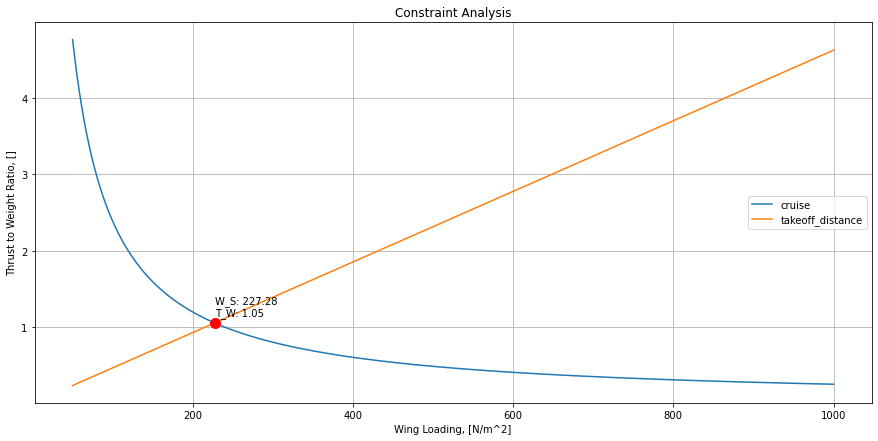

In [7]:
def constraint_analysis(funcs):
    """
    The main function that creates functions, solves the optimization problem, and then plots the constraint
    analysis diagram with the optimal design point labelled.
    """
    W_S_val = np.arange(50, 1000, 0.1)
    
    for f in funcs:
        plt.plot(W_S_val, f(W_S_val), label=f.__name__)
    plt.xlabel('Wing Loading, [N/m^2]')
    plt.ylabel('Thrust to Weight Ratio, []')
    plt.grid()
    plt.legend()
    plt.title('Constraint Analysis')
    
    opt_sol = solve(funcs)
    plt.plot(opt_sol['W_S'], opt_sol['T_W'], 'r.', markersize=20, label='design point')
    plt.text(opt_sol['W_S'], opt_sol['T_W'] + 0.1, 'W_S: {W_S:0.2f}\nT_W: {T_W:0.2f}'.format(**opt_sol))

    
constraint_analysis([cruise, takeoff_distance])